# OpenEO Time Series
In this Notebook, we will demonstrate the OpenEO functionalities to efficiently extract time series from a Data Cube.
Let's calculate a time series of the average NDVI in a couple of fields in this area.

First, import the necessary modules and load the fields as shapely geometries.

In [25]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import sys
import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

## Loading the Data Cube

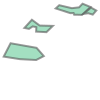

In [6]:
with open("fields.geojson") as f:
    features = json.load(f)["features"]
    fields = shapely.geometry.GeometryCollection([shapely.geometry.shape(ftr["geometry"]) for ftr in features])
fields

## Time series extraction
Like before, we load a Data Cube and calculate the NDVI, but we now use a larger time window covering a couple of months.
Also note that we don't have to specify a bounding box explicitly when loading the cube, because we will pass the desired fields in a next step and the backend will limit the data loading to those areas appropriately.

In [16]:
con  = openeo.connect("https://openeo.vito.be").authenticate_oidc(provider_id="egi")
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B08", "SCL"]
dates = ("2020-06-01", "2020-10-01")

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", temporal_extent=dates, bands=bands)

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

Authenticated using refresh token.


With the ```DataCube.aggregate_spatial()``` method , we can calculate the mean NDVI for each of the fields.

In [17]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

We trigger execution by downloading the result. <br> 
Because ```DataCube.aggregate_spatial()``` returns a timeseries (instead of raster data), we download it in JSON format.

In [18]:
timeseries.download("timeseries.json", format="JSON")

Using the helper function ```openeo.rest.conversions.timeseries_json_to_pandas``` the JSON structure is converted to a Pandas Dataframe.<br>
Then, show the first rows of the DataFrame.

In [19]:
with open("timeseries.json") as f:
    ts = timeseries_json_to_pandas(json.load(f)).dropna()
ts.index = pd.to_datetime(ts.index)
ts.head()

polygon,0,1,2,3
date,,,,
2020-06-01 00:00:00+00:00,0.748476,0.495063,0.655510,0.486538
2020-06-04 00:00:00+00:00,0.028493,0.026855,0.026339,0.026769
2020-06-06 00:00:00+00:00,0.760013,0.501150,0.694817,0.394088
2020-06-11 00:00:00+00:00,0.024885,0.026817,0.028701,0.026536
2020-06-14 00:00:00+00:00,0.000000,0.000000,0.000000,0.000244


## Time series plot and masking
Now we will plot the timeseries. First, the ```plot_timeseries``` function is defined.

In [32]:
DEFAULT_FIGSIZE = (5, 4)

def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    
    ts.index = pd.to_datetime(ts.index)
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); 
    ax.set_ylabel("NDVI");
    ax.set_ylim(-0.05, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

polygon                      0         1         2         3
date                                                        
2020-06-01T00:00:00Z  0.748476  0.495063  0.655510  0.486538
2020-06-04T00:00:00Z  0.028493  0.026855  0.026339  0.026769
2020-06-06T00:00:00Z  0.760013  0.501150  0.694817  0.394088
2020-06-11T00:00:00Z  0.024885  0.026817  0.028701  0.026536
2020-06-14T00:00:00Z  0.000000  0.000000  0.000000  0.000244
2020-06-16T00:00:00Z  0.042587  0.193620  0.000000  0.000000
2020-06-19T00:00:00Z  0.749516  0.476890  0.386062  0.483737
2020-06-21T00:00:00Z  0.888410  0.633548  0.845513  0.745830
2020-06-24T00:00:00Z  0.669581  0.611985  0.715298  0.792830
2020-06-26T00:00:00Z  0.566002  0.617268  0.649186  0.795345
2020-06-29T00:00:00Z  0.000000  0.000000  0.000000  0.000000
2020-07-01T00:00:00Z  0.000000  0.000000  0.000000  0.000000
2020-07-06T00:00:00Z  0.000000  0.000000  0.000000  0.000000
2020-07-09T00:00:00Z  0.000000  0.000000  0.000000  0.000000
2020-07-11T00:00:00Z  0.

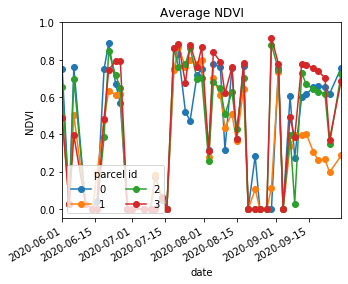

In [30]:
plot_timeseries("timeseries.json")

The result above is a good start, but needs some more work: there are quite some outliers and zeros that don't look right. <br>
This is due to cloudy observations that cause unusable NDVI values. We will add some cloud masking to generate a cleaner time series.

In [22]:
#define the masking kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

dates = ("2020-06-01", "2020-10-01")

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

Then apply the masking to the time series.

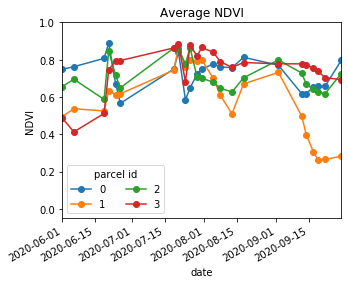

In [33]:
masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")
masked_timeseries.download("timeseries-masked.json", format="JSON")
plot_timeseries("timeseries-masked.json")

That looks a lot cleaner now, the very low NDVI values due to cloud contamination have disappeared.